In [1]:
%matplotlib ipympl

In [2]:
import cv2
import pickle
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import glob

In [3]:
path_current = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.split(path_current)[0])

from app_sys import AppSys
from utils_predict import standardize_fsize_coord_conversion, standardize_fsize
from utils import Holds, WallKeypoints

app_sys = AppSys()

In [4]:
t = 100

# 1. Load kp coords

The coordinates recorded on tkinter canvas for squared (640x640) image

In [5]:
direc = os.path.join(app_sys.PATH_ASSET, 'concept_test')

In [6]:
os.listdir(direc)

['img1.pkl', 'camera_calibration', 'img0.pkl', 'kp1.pkl', 'kp0.pkl']

In [7]:
direc_img = pickle.load(open(os.path.join(direc,'img0.pkl'), 'rb'))
kp = pickle.load(open(os.path.join(direc,'kp0.pkl'), 'rb'))

In [8]:
print(direc_img)
direc_img_depth = direc_img.replace('original', 'depth')
print(direc_img_depth)

/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_original.jpg
/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_depth.jpg


# 2. Depth information

In [9]:
depth_array = np.load(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_depths.npz'))
depth_array

NpzFile '/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_depths.npz' with keys: depths

frame numbers, height, width

In [10]:
depth = depth_array['depths']

In [11]:
depth.shape

(654, 1280, 720)

The closer the larger the values -> the inverse distance is recorded

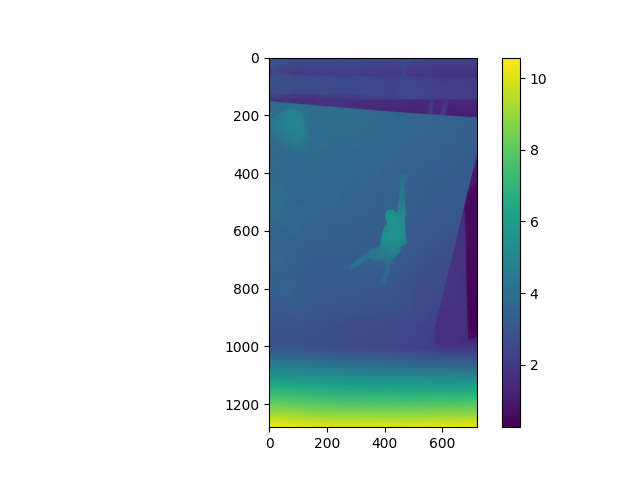

Max: 10.572931289672852, Min: 0.2531845271587372


In [12]:
plt.imshow(depth[t,:,:])
plt.colorbar()
plt.show()
print(f"Max: {depth[t,:,:].max()}, Min: {depth[t,:,:].min()}")

# 3. KP coordinates conversion from the square frame to the original frame

In [13]:
df_sq = pd.DataFrame(index=kp.get_node_names(), columns=['X', 'Y', 'Z'])
df_sq = df_sq.astype(float)
for key in df_sq.index:
    df_sq.loc[key, ['X', 'Y']] = kp.get_node_coords(key)

## Coordinates of the KPs on the square frame

In [14]:
df_sq

,X,Y,Z
A1,180.0,362.0,NaN
A4,181.0,325.0,NaN
A8,181.0,277.0,NaN
A11,182.0,236.0,NaN
A14,183.0,190.0,NaN
A18,184.0,118.0,NaN
C4,210.0,328.0,NaN
C6,211.0,304.0,NaN
C9,215.0,265.0,NaN
C12,217.0,221.0,NaN


## Coordinates of the KPs on the original video frames

Save the depth information

In [15]:
video = cv2.VideoCapture('/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_vis.mp4')
video.set(cv2.CAP_PROP_POS_FRAMES, t)
res, frame = video.read()

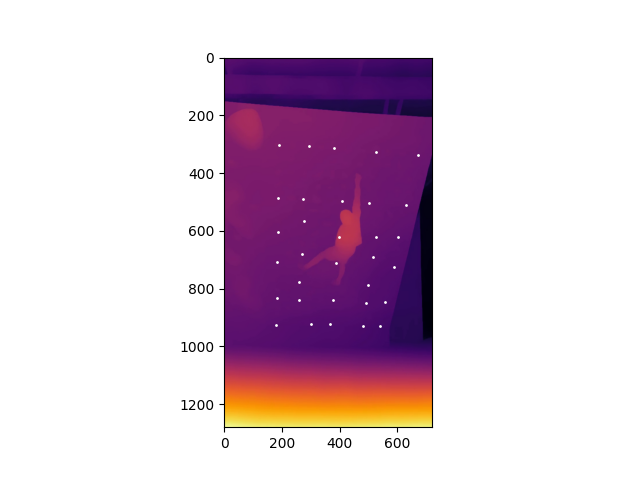

In [16]:
fig, ax = plt.subplots()
frame_depth = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
ax.imshow(frame_depth)

df = df_sq.copy()
# DF of the depth value
for k in df_sq.index:
    xx, yy = df_sq.loc[k, ['X', 'Y']]
    # Coordinates before reshaping the frame to 640x640
    x, y = standardize_fsize_coord_conversion(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_vis.mp4'), 640, (xx/500*640,yy/500*640))
    # ax.scatter(int(x), int(y), facecolors='none', color='white')
    ax.scatter(int(x), int(y), color='white', s=1)
    # values need to be inverted as they are likely inverse depth for visualisation purpose
    z = 1/(depth[t,y,x] + 1e-9) * 1000
    df.loc[k, ['X', 'Y', 'Z']] = (x,y,z)


In [17]:
df

,X,Y,Z
A1,181.0,927.0,351.625563
A4,183.0,832.0,318.357594
A8,183.0,709.0,299.466126
A11,186.0,604.0,284.498718
A14,188.0,486.0,268.263664
A18,191.0,302.0,253.798610
C4,258.0,840.0,323.958251
C6,260.0,778.0,316.084919
C9,270.0,678.0,293.095406
C12,276.0,566.0,285.231706


# 4. 3D visualisation of the KPs

In [18]:
dict_col = {
    'A':'red',
    'C':'orange',
    'D':'yellow',
    'E':'green',
    'F':'green',
    'H':'blue',
    'I':'navy',
    'K':'purple',
    }

Text(0.5, 0, 'Z')

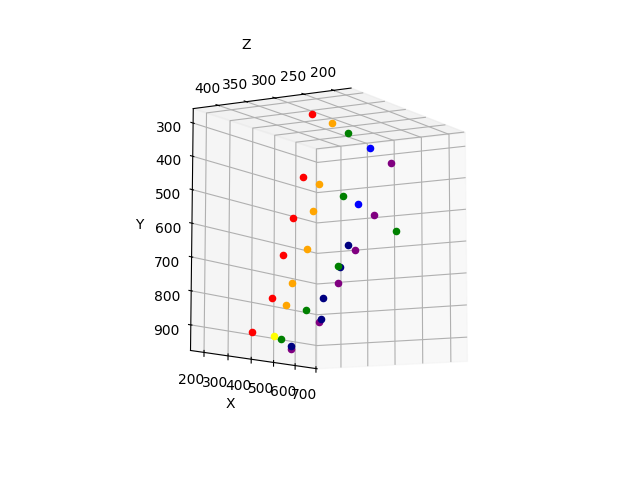

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df.index:
    x, y, z = df.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 5. Get the best fit plane

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

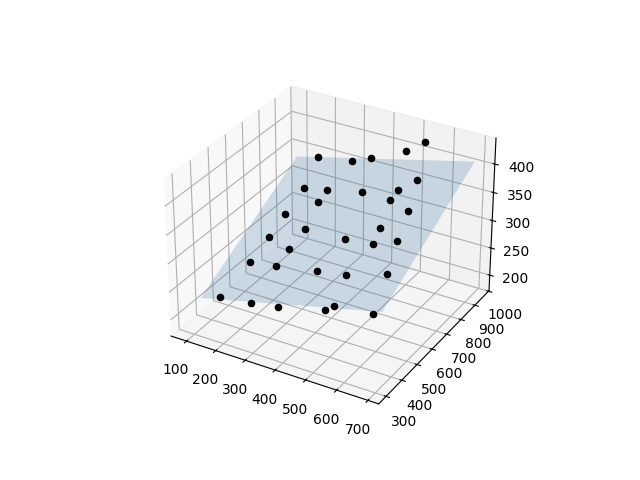

In [20]:
points = Points(df.astype(float))
plane = Plane.best_fit(points)

plot_3d(
    points.plotter(c='black', s=20, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-300, 300), lims_y=(-300, 300)),
)

# 6.  Projection of the KPs on the best fit plane

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

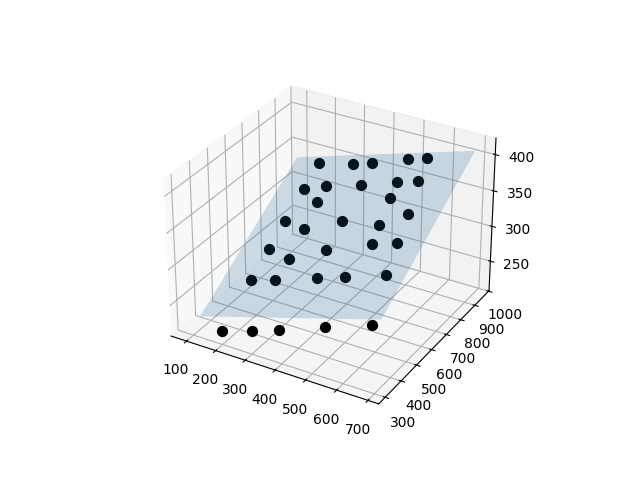

In [21]:
points2 = plane.project_points(df.astype(float))
plot_3d(
    points2.plotter(c='k', s=50, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-300, 300), lims_y=(-300, 300)),
)

In [22]:
df_fit = pd.DataFrame(points2, index=df.index, columns=df.columns)
df_fit

,X,Y,Z
A1,182.404128,929.133468,340.345739
A4,182.563008,831.336024,321.868092
A8,183.080791,709.122755,298.817109
A11,186.615872,604.935771,279.551218
A14,189.306741,487.985495,257.766186
A18,194.670604,307.577209,224.311435
C4,256.941523,838.391723,332.461349
C6,259.368321,777.040211,321.159405
C9,268.738340,676.083002,303.230735
C12,276.227129,566.345105,283.407106


Text(0.5, 0, 'Z')

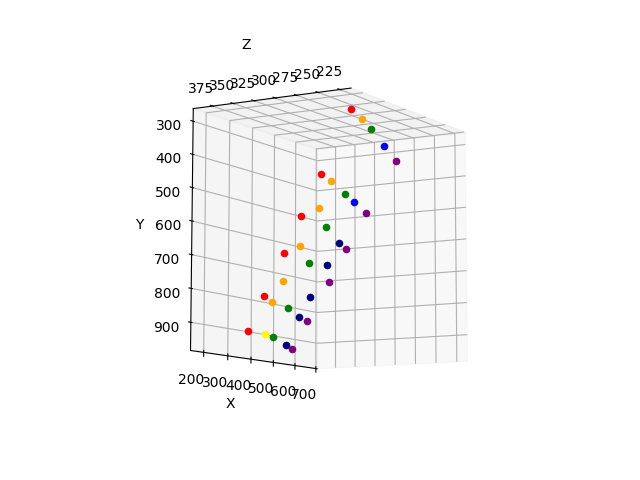

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df_fit.index:
    x, y, z = df_fit.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 8. Pseudo 3D coordinates of the KPs

Getting absolute X & Y coordinates assuming that Z we obtained are absolute depth

For most smartphone cameras, the principal point is near the center of the image:

In [ ]:


def get_camera_matrix(direc_cariburation_imgs):
    # Define checkerboard properties
    CHECKERBOARD = (9, 6)  # (internal corners per row, per column)
    square_size = 0.015  # Set the square size in meters (e.g., 2.5cm = 0.025m)

    # Arrays to store object points and image points
    objpoints = []  # 3D world points
    imgpoints = []  # 2D image points

    # Define real-world 3D points for the checkerboard
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size

    # Load all images from folder
    images = glob.glob(direc_cariburation_imgs + '/camera_calibration/*.JPG')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect checkerboard corners
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
        
        if ret:
            print(f"✅ Pattern detected in {fname}")
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        else:
            print(f"❌ Pattern NOT detected in {fname}")

    # Camera calibration
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Print results
    print("\nCamera Matrix (K):\n", K)
    print("\nDistortion Coefficients (D):\n", dist)
    return K, dist


In [25]:
K, dist = get_camera_matrix(direc)

✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220112594LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220030216LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220057089LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220114955LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220019763LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220059527LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220016416LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220103774LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220046168

In [26]:
fx, fy = K[0,0], K[1,1]
cx, cy = K[:2,2]
print(f'fx, fy: {fx, fy}px\ncx, cy: {cx, cy}px')

fx, fy: (1353.6916013193747, 1357.5577175771411)px
cx, cy: (538.9620163208962, 961.5329947833661)px


## Estimate absolute X and Y (Not essential now)

X = (x-cx)/fx*Z

Y = (y-cy)/fy*Z


In [27]:
def abs_xy(row):
    return (row['X'] - cx)/fx*row['Z'], (row['Y'] - cy)/fy*row['Z'], row['Z']

In [28]:
df_abs = df_fit.apply(abs_xy, axis=1, result_type='expand')
df_abs.columns = ['X', 'Y', 'Z']
df_abs

,X,Y,Z
A1,-89.645941,-8.122705,340.345739
A4,-84.741213,-30.868854,321.868092
A8,-78.558070,-55.558962,298.817109
A11,-72.763097,-73.431271,279.551218
A14,-66.580384,-89.914802,257.766186
A18,-57.050292,-108.054161,224.311435
C4,-69.263127,-30.156886,332.461349
C6,-66.332793,-43.645726,321.159405
C9,-60.530865,-63.759507,303.230735
C12,-55.005833,-82.500401,283.407106


Text(0.5, 0, 'Z')

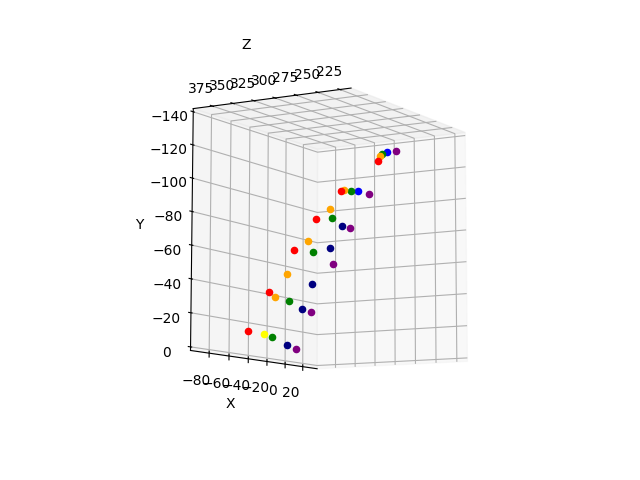

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df_abs.index:
    x, y, z = df_abs.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Fit a plane and get projections of the KPs on the plane

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

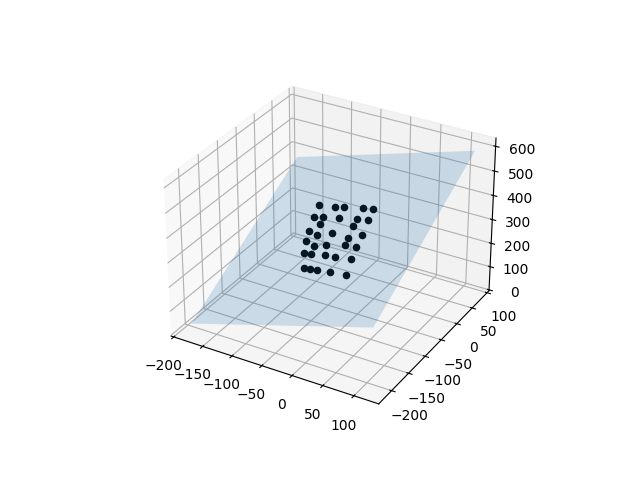

In [30]:
points = Points(df_abs.astype(float))
plane = Plane.best_fit(points)

plot_3d(
    points.plotter(c='black', s=20, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-150, 150), lims_y=(-150, 150)),
)

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

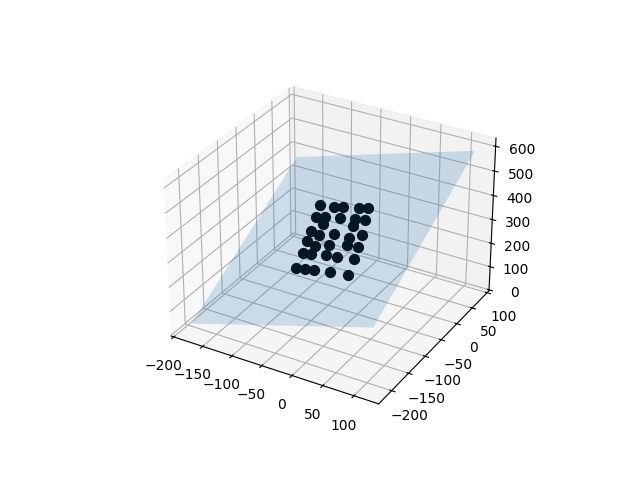

In [31]:
points2 = plane.project_points(df_abs.astype(float))
plot_3d(
    points2.plotter(c='k', s=50, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-150, 150), lims_y=(-150, 150)),
)

In [32]:
df_abs_fit = pd.DataFrame(points2, index=df.index, columns=df.columns)
df_abs_fit

,X,Y,Z
A1,-88.744115,-6.743309,339.114490
A4,-82.943921,-28.119789,319.414277
A8,-76.739506,-52.777362,296.334252
A11,-71.859609,-72.049332,278.317699
A14,-67.735671,-91.681881,259.343481
A18,-63.482766,-117.893010,233.093592
C4,-67.870227,-28.026363,330.559644
C6,-64.503407,-40.847573,318.661773
C9,-58.608168,-60.818628,300.605706
C12,-53.837355,-80.713145,281.811801


Text(0.5, 0, 'Z')

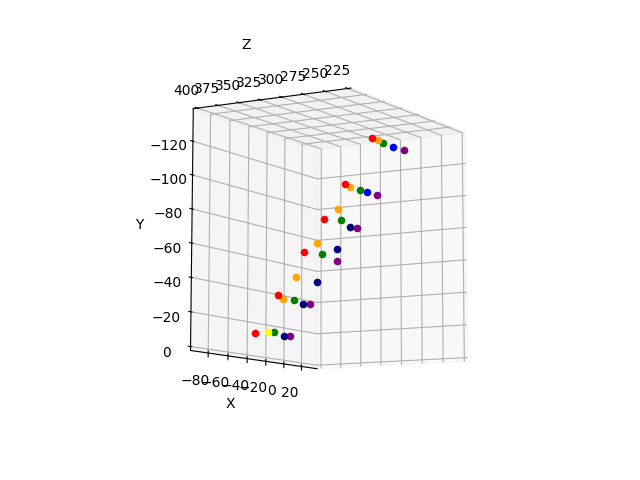

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.invert_zaxis()
ax.view_init(elev=-30, azim=170, roll=95)
for k in df_abs_fit.index:
    x, y, z = df_abs_fit.loc[k, ['X', 'Y', 'Z']]
    ax.scatter(x, y, z, c=dict_col[k[0]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 9. Human pose estimation (3D)

In [34]:
from humanpose.pose3d import Body
from humanpose.keypoints import get_edge_coords_all

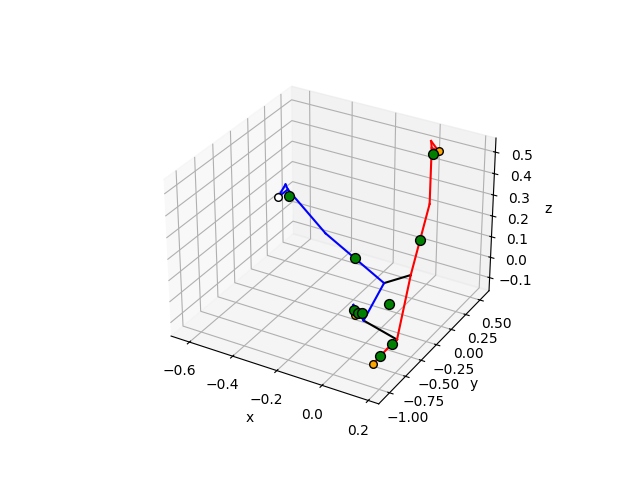

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
body = Body(t)
body.plot(ax)
plt.show()

In [36]:
body.coords2d[t][:,0]
body.coords2d[t][:,1]

array([    0.43212,     0.43037,     0.43137,     0.43227,     0.42724,     0.42622,     0.42516,     0.43577,     0.43002,     0.43795,     0.43461,     0.46902,     0.43941,      0.4833,      0.3868,     0.47668,     0.34327,     0.47555,     0.33004,      0.4731,     0.32975,     0.47278,     0.33421,     0.52813,
           0.52661,     0.53852,     0.55393,     0.56707,     0.59662,     0.57638,     0.60433,     0.56025,     0.60495])

# 10. Solve PnP to standardize the viewpoint

In [37]:
def solvePnP(world_coords, img_coords):
    """
    PnP solver for the wall and human pose
    """
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        world_coords,
        img_coords,
        K,
        dist,
        flags=cv2.SOLVEPNP_ITERATIVE,
        reprojectionError=8.0,
        confidence=0.99
    )

    if success:
        print("Rotation Vector:\n", rvec)
        print("Translation Vector:\n", tvec)
        return rvec, tvec
    else:
        print("PnP RANSAC failed.")
        return None, None

In [38]:
kps = WallKeypoints('example', inverty=True)
coords_3d = kps.get_node_coords_all_3d()
img_coords = []
world_coords = []
for key in kps.get_node_names():
    img_coords.append(tuple(df.loc[key,['X', 'Y']]))
    # img_coords.append(tuple(df_fit.loc[key,['X', 'Y']]))
    world_coords.append(coords_3d[key])
world_coords = np.array(world_coords).astype('float32')
img_coords = np.array(img_coords).astype('float32')

In [39]:
rvec, tvec = solvePnP(world_coords, img_coords)

Rotation Vector:
 [[     1.4849]
 [   -0.19346]
 [    0.17173]]
Translation Vector:
 [[    -1080.9]
 [    -119.84]
 [     8175.1]]


In [40]:
# Map the 3D point to 2D point 
points_2d, _ = cv2.projectPoints(world_coords, 
                                 rvec, tvec, 
                                 K, 
                                 dist) 

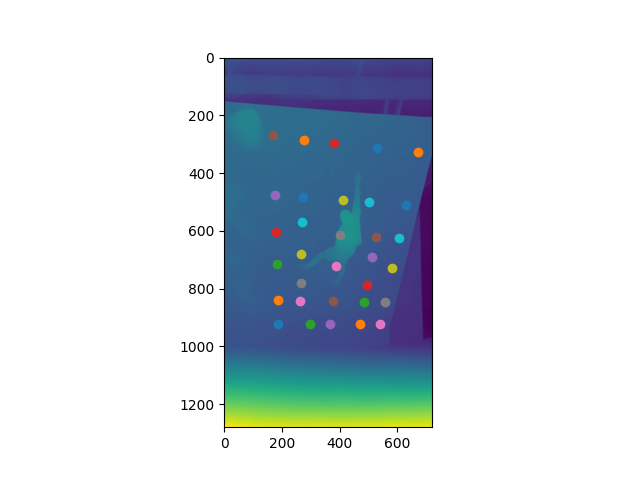

In [41]:
fig, ax = plt.subplots()
ax.imshow(depth[t,:,:])
for coords in points_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy)

In [42]:
kwargs = {
    'inverty': True,
    'rvec': rvec,
    'tvec': tvec, 
    'K': K, 
    'dist': dist

}
holds = Holds(**kwargs)
coords2d_holds = holds.get_projection()

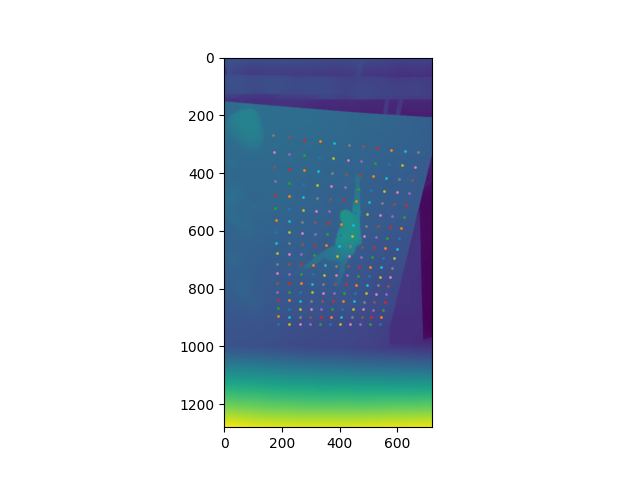

In [43]:
fig, ax = plt.subplots()
ax.imshow(depth[t,:,:])
for hold_name, coords in coords2d_holds.items():
    xx, yy = coords[0]
    ax.scatter(xx, yy, s=1)

In [44]:
ny, nx = depth[t,:,:].shape

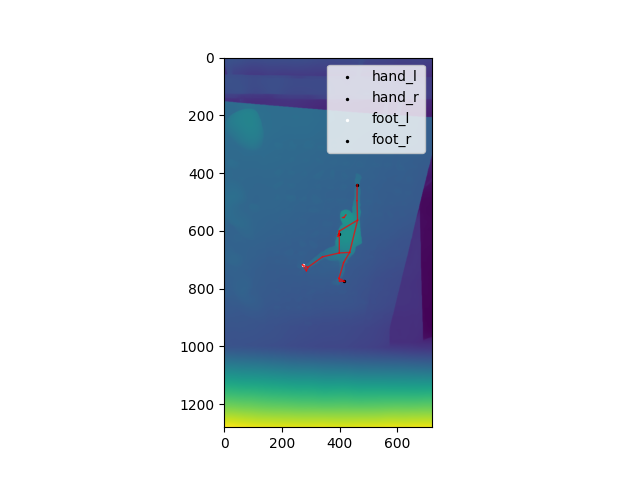

In [45]:
fig, ax = plt.subplots()
ax.imshow(depth[t,:,:])
for k, v in body.contact_points2d.dict_points.items():
    state = v['state']
    coords = v['coords']
    v['coords'] = [coords[0]*nx, coords[1]*ny]
    ax.scatter(coords[0]*nx, coords[1]*ny, s=2, c=['white', 'black'][state], label=k)
for k, v in body.edges2d.items():
    p0, p1 = v
    ax.plot([p0[0]*nx, p1[0]*nx], [p0[1]*ny, p1[1]*ny], c='red', alpha=0.7, lw=1)
ax.legend()

Pseudo 3D coordinates for the human pose

Solve PnP for human pose

- Assuming that the MediaPipe 3D coords are absolute coordinates.
- Try to match the perspective in the frame.

In [46]:
def get_wrld_coords(t):
    world_coords_pose = []
    for c0, c1, c2 in body.coords3d[t]:
        # world_coords_pose.append([-c0 * 1e3, c2 * 1e3, -c1 * 1e3])
        world_coords_pose.append([c0 * 1e3, -c1 * 1e3, c2 * 1e3])
    return np.array(world_coords_pose).astype('float32')

In [47]:
def get_img_coords(t):
    df_pose2d = pd.DataFrame(columns=['X','Y'])
    df_pose2d['X'] = np.array(body.coords2d[t][:,0])*nx
    df_pose2d['Y'] = np.array(body.coords2d[t][:,1])*ny
    img_coords_pose = []
    for i in df_pose2d.index:
        img_coords_pose.append(list(df_pose2d.loc[i,['X', 'Y']]))
    return np.array(img_coords_pose).astype('float32')

In [48]:
world_coords_pose = get_wrld_coords(t)
img_coords_pose = get_img_coords(t)

In [49]:
rvec_pose, tvec_pose = solvePnP(world_coords_pose, img_coords_pose)

Rotation Vector:
 [[    -2.7118]
 [  -0.094751]
 [    0.23632]]
Translation Vector:
 [[    -563.86]
 [    -1249.8]
 [     6145.9]]


In [57]:
# Map the 3D point to 2D point 
pose_2d, _ = cv2.projectPoints(world_coords_pose, 
                                 rvec_pose, tvec_pose, 
                                 K, 
                                 dist)

wall_2d, _ = cv2.projectPoints(world_coords, 
                                 rvec, tvec, 
                                 K, 
                                 dist) 

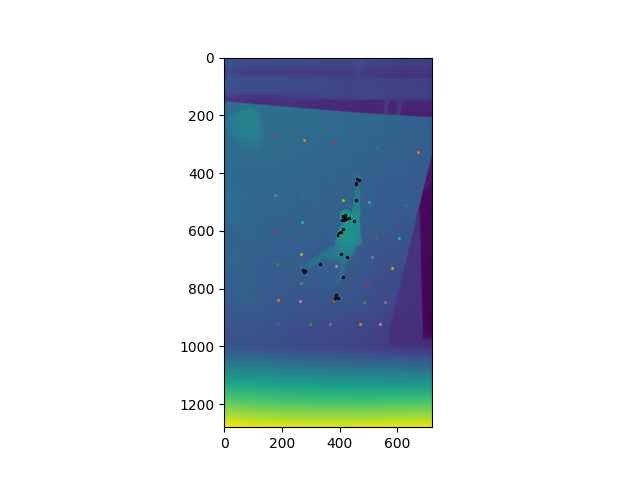

In [58]:
fig, ax = plt.subplots()
ax.imshow(depth[t,:,:])
for coords in pose_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy, c='black', s=1.5)

for coords in wall_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy, s=1)

Get the coordinates of holds contacted by hands/feet

Match the XY coordinates of 3D coords to that of 2D coords.

In [76]:
def local2global_coords(rvec_wall, tvec_wall, rvec_pose, tvec_pose, world_coords_pose):
    """
    Convert the 3D human pose coordinates around the hip to global coordinates
    rvec_wall, tvec_wall: rotation & translation vectors obtained by solving PnP for the wall    
    world_coords_pose: 3D coordinates of the human pose in the video frame pov
    
    """

    # Extrinsic matrix
    T_inv = np.eye(4)
    R_inv, _ = cv2.Rodrigues(-rvec_wall)
    T_inv[:3, :3] = R_inv
    T_inv[:3, 3] = -tvec_wall.flatten()

    # Extrinsic matrix
    T_pose = np.eye(4)
    R_pose, _ = cv2.Rodrigues(rvec_pose)
    T_pose[:3, :3] = R_pose
    T_pose[:3, 3] = tvec_pose.flatten()

    converted = []
    for x3d, y3d, z3d in world_coords_pose:
        # MediaPipe pov to frame pov
        xx, yy, zz, _ = T_pose@[x3d,y3d,z3d,1]
        # Frane pov to standardised pov
        x, y, z = R_inv@[xx,yy,zz]
        # converted.append([x-2000, y-8500, z+8500])
        converted.append([x, y, z])
        # converted.append([xx, yy, zz])
    return np.array(converted), R_inv

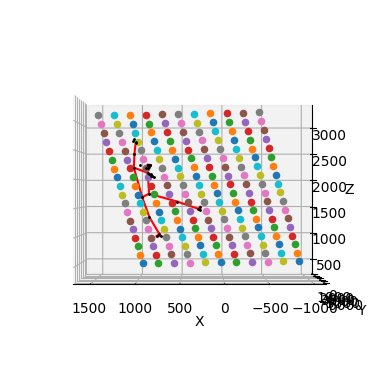

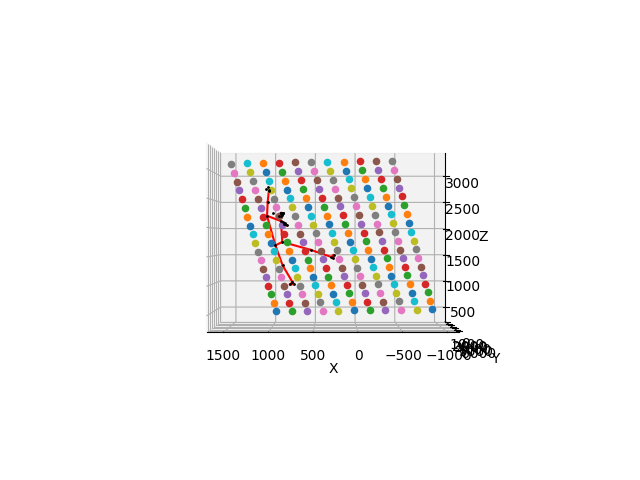

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')




coords_pose, R_inv = local2global_coords(rvec, tvec, rvec_pose, tvec_pose, world_coords_pose)
for x, y, z in coords_pose:
    ax.scatter(x, y, z, c='black', s=1)

for k, v in get_edge_coords_all(coords_pose).items():
    p0, p1 = v
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], c='red')


for k, v in holds.coords_world.items():
    xx, yy, zz = R_inv @ [v[0], v[1], v[2]]
    # ax.scatter(v[0], v[1], v[2], label=k)
    ax.scatter(xx, yy, zz, label=k)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(elev=4, azim=0, roll=-82)
ax.view_init(elev=0, azim=90, roll=0)
fig

In [54]:
body.edges2d.items()

dict_items([('sh', (array([    0.55373,     0.46902]), array([    0.64142,     0.43941]))), ('a_l', (array([    0.55373,     0.46902]), array([    0.54735,      0.4833]))), ('a_r', (array([    0.64142,     0.43941]), array([    0.63883,      0.3868]))), ('af_l', (array([    0.54735,      0.4833]), array([    0.55336,     0.47668]))), ('af_r', (array([    0.63883,      0.3868]), array([    0.63957,     0.34327]))), ('side_l', (array([    0.55373,     0.46902]), array([     0.5536,     0.52813]))), ('side_r', (array([    0.64142,     0.43941]), array([    0.60349,     0.52661]))), ('hp', (array([     0.5536,     0.52813]), array([    0.60349,     0.52661]))), ('thigh_l', (array([     0.5536,     0.52813]), array([    0.47312,     0.53852]))), ('thigh_r', (array([    0.60349,     0.52661]), array([     0.5746,     0.55393]))), ('shin_l', (array([    0.47312,     0.53852]), array([    0.40242,     0.56707]))), ('shin_r', (array([     0.5746,     0.55393]), array([    0.55236,     0.59662])

Coordinates around hip to global coordinates

In [55]:
confs = np.array(body.coords3d_conf)
nf, nkp = confs.shape

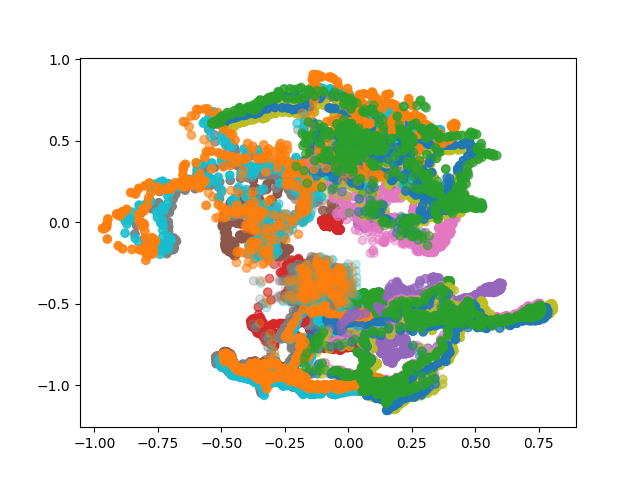

In [56]:
fig, ax = plt.subplots()
for i in range(nkp):
    ax.scatter(body.coords3d[:,i,0],body.coords3d[:,i,1], alpha=confs[:,i], label=i)
# ax.legend()